In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_svmlight_file
from torch.utils.data import Dataset, DataLoader
import os
import pickle

In [3]:
import pandas as pd
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

## Hyper Parameters

In [4]:
class arguments():
#     data = 'NSQIP'
    data = 'a9a'
    
    T = 1000 # Total number of iterations

    reg = 0.05 # reglularization parameter
    mu = reg # strong convexity of F

    beta = 1
    batch_size = 1 # number of data points used to obtain a stochastic gradient, at each iteration for each worker
    N = 10 # number of workers
    plot_every = 100 # frequency of evaluating the optimality error
    
    if data == 'a9a' and reg == 0.05:
        f_min = 0.433426
    elif data == 'NSQIP' and reg == 0.05:
        f_min = 0.228248
    else:
        f_min = None
        
    reps = 10
    print_every = reps // 5
    
    device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

arg = arguments()

cpu


In [18]:
def _get_dense_tensor(tensor):
    if 'sparse' in str(type(tensor)):
        return tensor.toarray()
    elif 'numpy' in str(type(tensor)):
        return tensor


def _correct_binary_labels(labels, is_01_classes=True):
    classes = set(labels)

    if -1 in classes and is_01_classes:
        labels[labels == -1] = 0
    return labels


class dataset(Dataset):
    def __init__(self, data_name):
        # load dataset.
        if data_name == 'a9a':
            file_path = 'data/a9a'
            dataset = load_svmlight_file(file_path)
            self.features, self.labels = self._get_images_and_labels(dataset)
            self.labels = np.reshape(self.labels, (-1,1))
            
        elif data_name == 'NSQIP':
            x_path = 'data/df_NSQIP_2014_post_x.pkl'
            y_path = 'data/Y.csv'
            df_features = pickle.load(open(x_path, 'rb'))
            df_labels = pd.read_csv(y_path, header=None)
            
            self.labels = df_labels.to_numpy(dtype = np.float32) # int
            self.features = min_max_scaler.fit_transform(df_features).astype(np.float32)
            
            del df_labels
            del df_features
            
        else:
            print('Error! Data name not recognized.')
            
        self.labels = torch.from_numpy(self.labels).to(arg.device)
        self.features = torch.from_numpy(self.features).to(arg.device)
            

    def _get_images_and_labels(self, data):
        features, labels = data
        
        features = _get_dense_tensor(features)
        labels = _get_dense_tensor(labels)
        
        labels = _correct_binary_labels(labels)
        
        features = features.astype(np.float32)
        labels = labels.astype(np.float32) #int
        return features, labels
    

    def __len__(self):
        return self.features.size(0)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return [self.features[idx], self.labels[idx]]

    def __iter__(self):
        idxs = list(range(self.__len__()))
        for k in idxs:
            yield [self.features[k], self.labels[k]]
    
    def get_data(self):
        return self.__iter__()

    def size(self):
        return self.__len__()
    
    def num_features(self):
        return self.features.shape[1]
    
    def get_batch(self, batch_size = 1, replace = False):
        idx = np.random.choice(self.__len__(), size = batch_size, replace = replace)
        return [self.features[idx], self.labels[idx]]

In [19]:
data_train = dataset(arg.data)
# data_train = dataset('NSQIP')

In [20]:
in_features = data_train.num_features()
print('Number of features: %d'%in_features)
print('Size of data: %d'%data_train.size())

Number of features: 231
Size of data: 722101


In [21]:
class Neuron(nn.Module):
    def __init__(self):
        super(Neuron, self).__init__()
        self.lin = nn.Linear(in_features,1)
        self.lin.weight.data = torch.zeros([1,in_features], requires_grad = True)
        self.lin.bias.data = torch.tensor([0.], requires_grad = True)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        x = self.lin(x)
        x = self.sig(x)
        return x

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

In [22]:
# an upper bound for the smoothness
fro_norm = torch.norm(data_train.features, p = 'fro')
L = ((fro_norm**2)/data_train.size()).item() + 1
print(L)

14.558308601379395


In [23]:
def get_total_loss(inputs, labels, network, reg = 0.0):
    with torch.no_grad():
        outputs = network(inputs)
        total_loss = criterion(outputs, labels)
        total_loss += 0.5*reg*(torch.norm(network.lin.weight)**2)
        total_loss += 0.5*reg*(torch.norm(network.lin.bias)**2)
    return total_loss.item()

In [24]:
net = Neuron().to(arg.device)
loss_0 = get_total_loss(data_train.features, data_train.labels, net, arg.reg)
print(loss_0) # Loss at the initial point

0.6931473016738892


## Find Global Optimum

In [15]:
net = Neuron().to(device)
avg_losses = [loss_0]
f_min = 1.0

optimizer = optim.SGD(net.parameters(), lr=1.0, weight_decay = arg.reg)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 2.0/(arg.mu*(t+1.0)), last_epoch=-1)

f_min: 0.433434


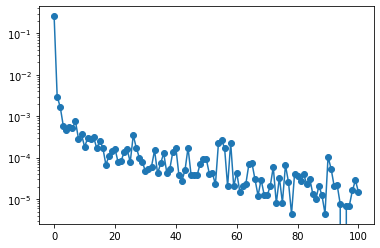

In [16]:
# This block can be run many times to find a more accurate optimum
bs_optimum = 50 # batch size used to find the global optimum

for t in range(10000):
    batch = data_train.get_batch(bs_optimum)
    inputs, labels = batch[0], batch[1]

    optimizer.zero_grad()
    logits = net(inputs)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    scheduler.step() #######<<<<<<<<<<-------- Comment this if you want to repeat this loop 
    
    if (t+1)%100 == 0:
        total_loss = get_total_loss(data_train.features, data_train.labels, net, arg.reg)
        avg_losses.append(total_loss)
        if total_loss<f_min:
            f_min = total_loss
#             print('new f_min: %f' %f_min)
            

print('f_min: %f' %  (f_min))

plt.plot(np.array(avg_losses) - f_min, '-o')
plt.yscale('log')
plt.show()

In [34]:
# arg.f_min = 0.433426 #a9a reg = 0.05
# arg.f_min = 0.228248 #NSQIP, reg = 0.05

## Centralized

In [25]:
iter_error_sum = np.zeros(arg.T//arg.plot_every + 1)

for rep in range(arg.reps):
#     print('Simulation: %d/%d'%(rep+1,arg.reps))
    
    iter_error = [loss_0]
    
    net = Neuron().to(arg.device)
    optimizer = optim.SGD(net.parameters(), lr=1.0, weight_decay = arg.reg)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 2.0/(arg.mu*(t+arg.beta)), last_epoch=-1)
    
    for t in range(arg.T):
        batch = data_train.get_batch(arg.N*arg.batch_size)
        inputs, labels = batch[0], batch[1]

        optimizer.zero_grad()
        logits = net(inputs)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if (t+1)% arg.plot_every == 0:
            total_loss = get_total_loss(data_train.features, data_train.labels, net, arg.reg)
            iter_error.append(total_loss)
            
        elif t == arg.T-1:
            total_loss = get_total_loss(data_train.features, data_train.labels, net, arg.reg)
#     print('loss: %.5f' %  (total_loss))

    iter_error_sum += np.array(iter_error)
    
    if (rep+1) % arg.print_every == 0:
            print('.', end='')
            
iter_error_avg = iter_error_sum/arg.reps    
print('Done!')

.....Done!


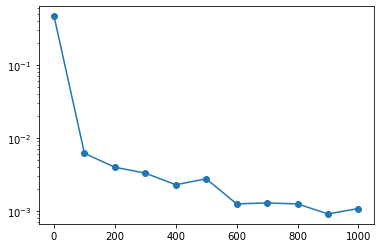

In [26]:
plt.plot(arg.plot_every*np.arange(len(iter_error_avg)), iter_error_avg - arg.f_min, '-o')
plt.yscale('log')
plt.show()

In [29]:
file_name = f"results/LR_cen_{arg.data}.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'arg': arg, 'iter_error_avg': iter_error_avg}, f)
    f.close()
print('file saved: ' + file_name)

file saved: results/LR_cen_NSQIP.pkl


In [30]:
file_name = f"results/LR_cen_{arg.data}.pkl"
data = pickle.load(open(file_name, 'rb'))
print(data.keys())

try:
    iter_error_cen = data['iter_error_avg']
#     arg = data['arg']
except:
    pass
del data

dict_keys(['arg', 'iter_error_avg'])


---
## Parallel

In [31]:
plot_labels = {0:r'Synchronous SGD', 1:r'[Sti19]', 2:'[HKMC19]', 3:'$H_i = a(i+1)$ [This Paper]', 4: r'$H = T/N$', 5:r'$H=T$ (OSA)'}

def get_comms(method, arg, N=None, T=None):
    if not N:
        N = arg.N
        T = arg.T
    
    if method == 0:
        comms = np.arange(T+1)
        print('synchronous')
        
    elif method == 1:
        H = int(np.sqrt(T/N))
        print(f"H={H}")
        
        comms = [H*t for t in range(T//H + 1)]
        plot_labels[method] = r'$H=%d$ [Sti19]' %H

    elif method == 2:
        H = int(((T**2)/N)**(1/3))
        print(f"H={H}")
        comms = [H*t for t in range(T//H + 1)]
        
        plot_labels[method] = r'$H=%d$ [HKMC19]' %H
        
    elif method == 3: # This Paper
        R = N #int(N*arg.kappa)
#         a = int(np.ceil(2*T/(k**2)))
        a = 2*T/(R*(R+1))
        print(f"R:{R}, a:{a}")
        plot_labels[method] = r'$H_i=%d(i+1)$ (This Paper)' % int(a)
        
        comms = [int(a*r*(r+1)/2) for r in range(R+1)]


    elif method == 4:
        R = N #int(N*arg.kappa)
        H = arg.T/R
        print(f"H={H}")
        comms = [int(np.ceil(H*r)) for r in range(R+1) if H*r <= T]
        plot_labels[method] = r'$H=%d$ $(T/N)$' %H

    elif method == 5:
        comms = [0,T]
        print(r'H=T (OSA)')

    if comms[-1] != T:
        comms.append(T)
        
    comms = np.array(comms, dtype = int)
#     print(comms)
    return comms

In [32]:
def train_dist(comms, arg):
    comm_error_sum = np.zeros(len(comms))
    iter_error_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    iter_error2_sum = np.zeros(np.ceil(arg.T/arg.plot_every + 1).astype(int))
    
    for rep in range(arg.reps):    
        workers = []
        all_params = []
        for i in range(arg.N):
            worker = Neuron().to(arg.device)
            workers.append(worker)
            all_params += list(worker.parameters())
            
        optimizer = optim.SGD(all_params, lr=1.0, weight_decay = arg.reg)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 3/(arg.mu*(t+arg.beta)), last_epoch=-1)
        
        comm_error = [loss_0]
        iter_error = [loss_0]
        for t in range(arg.T):
            optimizer.zero_grad()
            loss = 0
            for i in range(arg.N):
                worker = workers[i]
                batch = data_train.get_batch(arg.batch_size)
                inputs, labels = batch[0], batch[1]
                
                outputs = worker(inputs)
                loss += criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            if (t+1) in comms: # calculating the average of workers' parameters
                avg_net = Neuron().to(arg.device)
                params_avg = avg_net.named_parameters()
                dict_params_avg = dict(params_avg)

                for worker in workers:
                    for name, param in worker.named_parameters():
                        dict_params_avg[name].data.add_(param/arg.N)

                avg_net.load_state_dict(dict_params_avg)

                # updating each worker's parameters to the average
                for worker in workers:
                    worker.load_state_dict(dict_params_avg)

                total_loss = get_total_loss(data_train.features, data_train.labels, avg_net, arg.reg)
                comm_error.append(total_loss)


            if (t+1) % arg.plot_every == 0  or (t+1) == arg.T:
                # calculating the average of workers' parameters
                avg_net = Neuron().to(arg.device)
                params_avg = avg_net.named_parameters()
                dict_params_avg = dict(params_avg)

                for worker in workers:
                    for name, param in worker.named_parameters():
                        dict_params_avg[name].data.add_(param/arg.N)

                avg_net.load_state_dict(dict_params_avg)

                total_loss = get_total_loss(data_train.features, data_train.labels, avg_net, arg.reg)
                iter_error.append(total_loss)

        comm_error_sum += np.array(comm_error)
        iter_error_sum += np.array(iter_error)
        iter_error2_sum += np.array(iter_error)**2
        
        if (rep+1) % arg.print_every == 0:
            print('.', end='')
    
    print('Done!')

    comm_error_avg = comm_error_sum/arg.reps
    iter_error_avg = iter_error_sum/arg.reps
    iter_error2_avg = iter_error2_sum/arg.reps
    
    return {'comm_error_avg': comm_error_avg, 'iter_error_avg': iter_error_avg, 'iter_error2_avg': iter_error2_avg}

## Repeated Simulations

In [33]:
iter_avg_dict = {}
iter_std_dict = {}
comm_dict = {}

In [34]:
for method in [3,4,5,0]:
    print('method %d'% method)
    comms = get_comms(method, arg)
    print('# of comms: %d' % (len(comms)-1))
    
    result = train_dist(comms, arg)
    
    comm_dict[method] = result['comm_error_avg']
    iter_avg_dict[method] = result['iter_error_avg']
    iter_std_dict[method] = np.sqrt(result['iter_error2_avg'] - result['iter_error_avg']**2)/np.sqrt(arg.reps)

method 3
R:10, a:18.181818181818183
# of comms: 10
.....Done!
method 4
H=100.0
# of comms: 10
.....Done!
method 5
H=T (OSA)
# of comms: 1
.....Done!
method 0
synchronous
# of comms: 1000
.....Done!


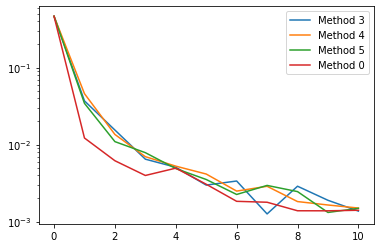

In [35]:
for method in iter_avg_dict:
    plt.plot(iter_avg_dict[method] - arg.f_min, label = 'Method %d' % method)

plt.yscale('log')
plt.legend()
plt.show()

plot_labels[4] = r'$H=100$ $(T/N)$'
plot_labels

In [17]:
# saving the results to a file
file_name = f"results/LR_dis_{arg.data}.pkl"
with open( file_name, 'wb') as f:
    pickle.dump({'iter_avg_dict': iter_avg_dict, 'iter_std_dict': iter_std_dict,
                 'comm_dict': comm_dict, 'arg': arg, 'plot_labels': plot_labels}, f)
    f.close()
print('file saved: ' + file_name)

file saved: results/LR_dis_a9a.pkl


In [18]:
# loading data
file_name = f"results/LR_dis_{arg.data}.pkl"
data = pickle.load(open(file_name, 'rb'))
print(f"file: {file_name} loaded.")
print(data.keys())

try:
    iter_avg_dict = data['iter_avg_dict']
    iter_std_dict = data['iter_std_dict']
    comm_dict = data['comm_dict']
    arg = data['arg']
    plot_labels = data['plot_labels']
    methods = iter_avg_dict.keys()
except:
    pass
del data

file: results/LR_dis_a9a.pkl loaded.
dict_keys(['iter_avg_dict', 'iter_std_dict', 'comm_dict', 'arg', 'plot_labels'])


## Plotting the results

In [6]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(6,4)}, 
    style="whitegrid" # nicer layout
)

In [19]:
# Combining the outputs in one dataframe for Seaborn
errors = []
txerrors = []

# errors_std = []
# txerrors_std = []

iterations = []
methods_list = []
for m in methods:
    errors = np.append(errors, iter_avg_dict[m]  - arg.f_min)
    txerrors = np.append(txerrors, (iter_avg_dict[m]- arg.f_min)*(arg.plot_every*np.arange(len(iter_avg_dict[m]))))

#     errors_std = np.append(errors_std, iter_std_dict[m])
#     txerrors_std = np.append(txerrors_std, iter_std_dict[m]*(arg.plot_every*np.arange(len(iter_std_dict[m]))))
    
    iterations = np.append(iterations, arg.plot_every*np.arange(len(iter_avg_dict[m])))
#     methods_list += [plot_labels[m]]*len(iter_avg_dict[m])
    methods_list += [m]*len(iter_avg_dict[m])


iter_df = pd.DataFrame({'iter': iterations, 'error': errors, 'txerror': txerrors, 'method': methods_list}) #, 'std': errors_std,  'txstd': txerrors_std})
iter_df.head()

,iter,error,txerror,method
0,0.0,0.259891,0.000000,3
1,100.0,0.107729,10.772905,3
2,200.0,0.028211,5.642267,3
3,300.0,0.019512,5.853603,3
4,400.0,0.009437,3.774995,3


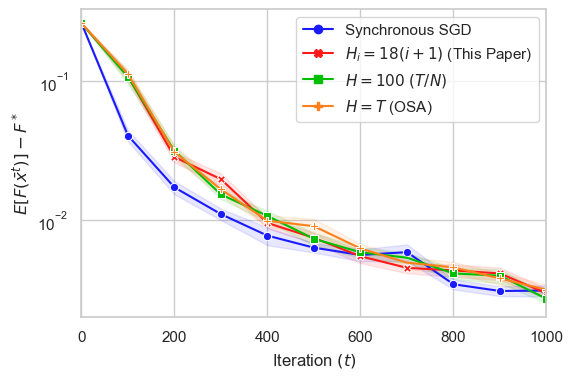

In [23]:
plot_colors = {0:(0.1, 0.1, 1),
               3:(1, 0.1, 0.1),
               4: (0,.75,0),
               5:(1,.5,0.1)}

ax = sns.lineplot(x = 'iter', y= 'error', data = iter_df,
                  hue = 'method',
#                   palette = 'bright',
                  palette = plot_colors,
                  style = 'method',
                  markers = True, dashes = False,   markevery=0.1)


# plt.plot(arg.plot_every*np.arange(len(iter_error_cen)),iter_error_cen - arg.f_min)

# plt.gca().set_prop_cycle(None)
for m in methods:
    iter_std = iter_std_dict[m]
    plt.fill_between(
        arg.plot_every*np.arange(len(iter_std)),
        (iter_avg_dict[m] - arg.f_min - iter_std),
        (iter_avg_dict[m] - arg.f_min + iter_std),
        alpha=0.1,
        color = plot_colors[m],
    )

plt.yscale('log')
plt.grid(True)
plt.xlabel(r'Iteration $(t)$')
plt.ylabel(r'$E[F(\bar x^t)] - F^*$')

# plt.ylim([5e-4,1e0])
plt.xlim([0,1000])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=[plot_labels[int(m)] for m in labels[1:]])
# plt.savefig(f"figures/iteration_{arg.data}.png", dpi=240, transparent=False, bbox_inches='tight')
plt.show()

In [24]:
# Combining the outputs in one dataframe for Seaborn
errors = []
comms = []
methods_list = []
for m in methods:
    errors = np.append(errors, comm_dict[m] - arg.f_min)
    comms = np.append(comms, np.arange(len(comm_dict[m])))
    methods_list += [m]*len(comm_dict[m])

comm_df = pd.DataFrame({'comm': comms, 'error': errors, 'method': methods_list})
comm_df.head()

,comm,error,method
0,0.0,0.259891,3
1,1.0,1.198220,3
2,2.0,0.324313,3
3,3.0,0.087955,3
4,4.0,0.035053,3


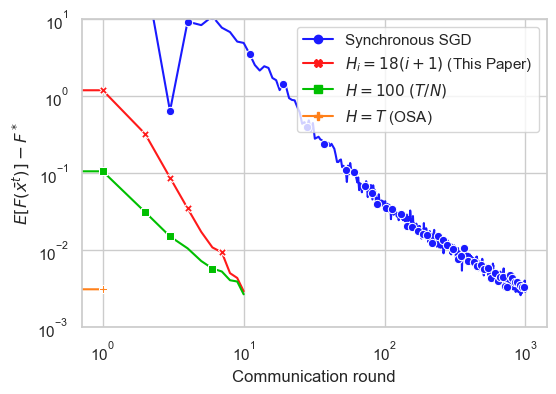

In [25]:
# plt.figure(figsize=(8,6))
ax = sns.lineplot(x = 'comm', y= 'error', data = comm_df, #.loc[comm_df['method'].isin([plot_labels[i] for i in [1,2,3,4]])],
                  hue = 'method',
#                   palette = 'bright',
                  palette = plot_colors,
                  style = 'method',  markers = True, dashes = False, markevery=.1)
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.xlabel(r'Communication round')
plt.ylabel(r'$E[F(\bar x^t)] - F^*$')
plt.ylim([1e-3, 1e1])
# plt.xlim([0,1000])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=[plot_labels[int(m)] for m in labels[1:]])
# plt.savefig(f"figures/communication_{arg.data}.png", dpi=240, transparent=False, bbox_inches='tight')
plt.show()